In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
START_TOKEN = '<START>'
END_TOKEN = '<END>'
np.random.seed(0)
random.seed(0)
# ----------------


[nltk_data] Downloading package reuters to
[nltk_data]     /home/kxfan2002/nltk_data...


In [3]:
END_TOKEN = '<END>'
def read_corpus(category="crude"):
    ''' 
    Read files from the specified Reuter's category.
    Params:
    category (string): category name
    Return:
    list of lists, with words from each of the processed files
    '''
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] +[END_TOKEN] for f in files]

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

In [6]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
    Params:
    corpus (list of list of strings): corpus of documents
    Return:
    corpus_words (list of strings): sorted list of distinct words␣
    ,→across the corpus
    num_corpus_words (integer): number of distinct words across the␣
    ,→corpus
    """
    corpus_words = []
    num_corpus_words = -1
    # ------------------
    # Write your implementation here.
    corpus_words = {word for doc in corpus for word in doc} # {} force it to be a set
    corpus_words = sorted(corpus_words)
    num_corpus_words = len(corpus_words)
    # ------------------
    return corpus_words, num_corpus_words

In [7]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------
# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN,END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN,END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)
# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold","All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)
# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)
# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours: {}".format(str(ans_test_corpus_words),str(test_corpus_words))
# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)


--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [8]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size(default of 4).
    Note: Each word in a document should be at the center of a window.Words near edges will have a smaller number of co-occurring words.
    For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,"All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    Params:
    corpus (list of list of strings): corpus of documents
    window_size (int): size of context window
    Return:
    M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
    Co-occurence matrix of word counts.
    The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
    word2ind (dict): dictionary that maps word to index (i.e. row/ column number) for matrix M.
    """
    words, num_corpus_words = distinct_words(corpus)
    M = None
    word2ind = {}
    # ------------------
    # Write your implementation here.
    # Build the word to index mapping.
    for i,word in enumerate(words):
        word2ind[word]=i

    M = np.zeros((num_corpus_words,num_corpus_words))
    for doc in corpus:
        for i in range(len(doc)):
            for j in range(1,min(window_size+1,len(doc)-i)):
                M[word2ind[doc[i]]][word2ind[doc[i+j]]]+=1
            for j in range(1,min(window_size+1,i+1)):
                M[word2ind[doc[i]]][word2ind[doc[i-j]]]+=1
    # ------------------
    return M, word2ind

In [9]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [12]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words,num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    M_reduced = np.zeros((M.shape[0],k)) # rank (M.shape[0],k),without the () will be a one dimension matrix
    lsa = TruncatedSVD(n_components=k, n_iter=n_iters) # give a method of svd by giving the target k and no of iterations
    M_reduced = lsa.fit_transform(M) # perform the svd and do the truncation
    # print(M_reduced)
    
    # ------------------

    print("Done.")
    return M_reduced

In [15]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
# pprint.pprint(test_corpus)
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)


[['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>'],
 ['<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']]
Running Truncated SVD over 10 words...
[[ 6.54802087e-01 -7.83221122e-01]
 [ 5.20200324e-01  1.72084569e-15]
 [ 7.05647176e-01  4.84057274e-01]
 [ 7.05647176e-01 -4.84057274e-01]
 [ 1.02780472e+00  4.44089210e-16]
 [ 6.54802087e-01  7.83221122e-01]
 [ 3.82258491e-01  6.56224003e-01]
 [ 3.82258491e-01 -6.56224003e-01]
 [ 1.39420808e+00 -1.06179274e+00]
 [ 1.39420808e+00  1.06179274e+00]]
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [26]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
    NOTE: do not plot all the words listed in M_reduced / word2ind.
    Include a label next to each point.
    Params:
    M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
    word2ind (dict): dictionary that maps word to indices for matrix M
    words (list of strings): words whose embeddings we want to visualize
    """
    # ------------------
    # Write your implementation here.
    for word in words:
        x = M_reduced[word2ind[word]][0]
        y = M_reduced[word2ind[word]][1]
        plt.scatter(x, y)
        plt.text(x, y, word, fontsize=9)
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


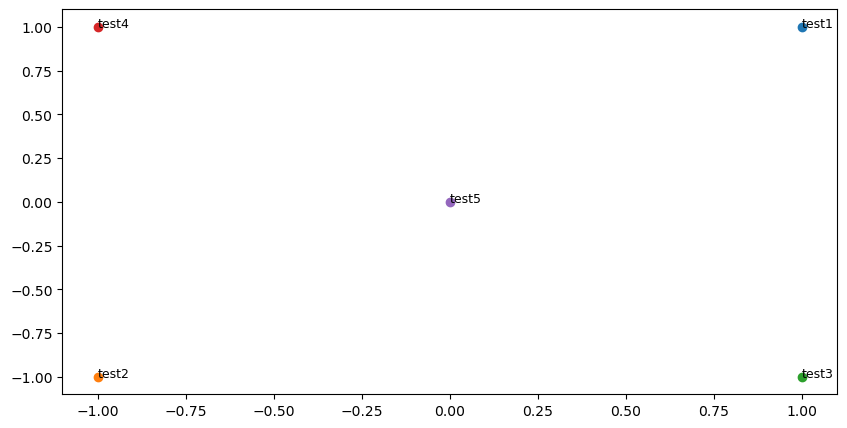

--------------------------------------------------------------------------------


In [27]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------
print ("-" * 80)
print ("Outputted Plot:")
M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)
print ("-" * 80)

Running Truncated SVD over 8185 words...
[[ 7.32630060e+02 -1.16894192e+02]
 [ 1.26000427e+00 -1.61923588e-01]
 [ 2.80304332e-01  6.47334603e-02]
 ...
 [ 1.04145879e+00 -3.06320300e-01]
 [ 6.19972477e-01 -1.25537234e-01]
 [ 2.42230659e+00  2.28089719e-01]]
Done.


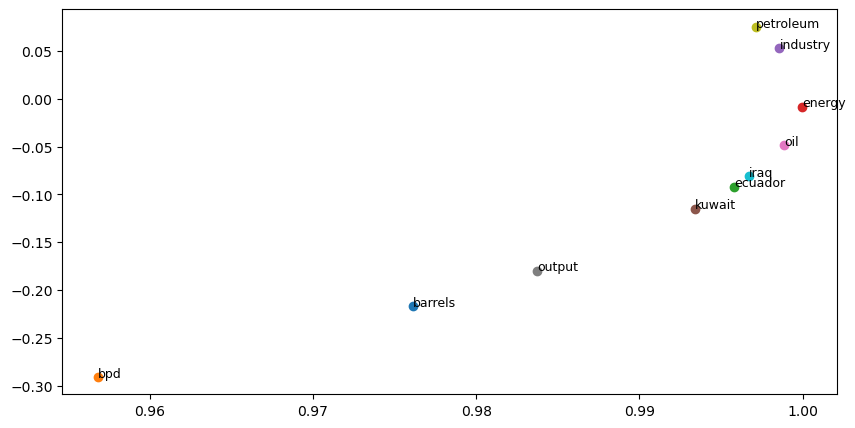

In [28]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_normalized, word2ind_co_occurrence, words)


图中主要有三个点簇：石油与工业，能源，伊朗与科威特与厄瓜多尔

oil与petroleum是同义词，应该更加接近

In [33]:
def load_embedding_model():
    """ Load GloVe Vectors
    Return:
    wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.index_to_key))
    return wv_from_bin


In [34]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [37]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
    Param:
    wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
    Return:
    M: numpy matrix shape (num words, 200) containing the vectors
    word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind


In [38]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting


Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
[[-1.1722748  -0.45696324]
 [ 0.10674405 -1.0439124 ]
 [-0.66153735 -0.98775613]
 ...
 [ 2.181188   -1.5345665 ]
 [ 1.7537785  -0.2864863 ]
 [ 3.2229218  -0.4639848 ]]
Done.


/tmp/ipykernel_333/1051677497.py:21: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))
/tmp/ipykernel_333/1051677497.py:30: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))


In [40]:
print(M.shape)

(10010, 200)


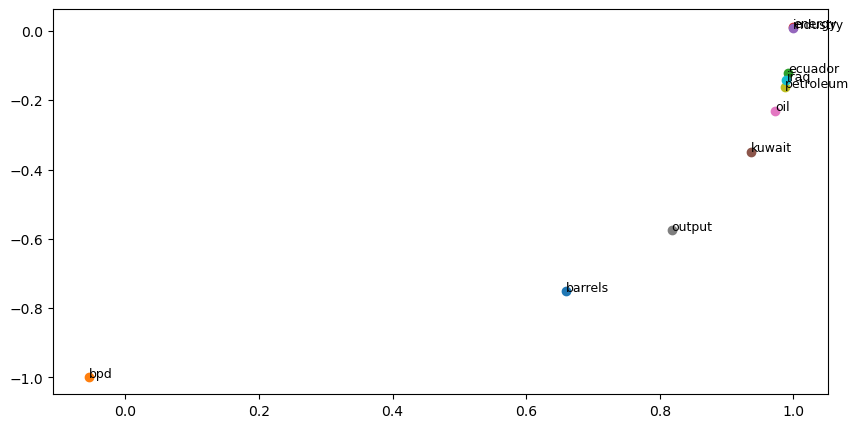

In [41]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

In [42]:
result = wv_from_bin.most_similar('open')
pprint.pprint(result)


[('opening', 0.6419216394424438),
 ('round', 0.6360391974449158),
 ('opens', 0.6174360513687134),
 ('opened', 0.5827721953392029),
 ('next', 0.5660091042518616),
 ('through', 0.5608601570129395),
 ('tournament', 0.5605131983757019),
 ('closed', 0.5601108074188232),
 ('tennis', 0.5498055815696716),
 ('set', 0.5496442914009094)]


In [43]:
result = wv_from_bin.most_similar('mango')
pprint.pprint(result)

[('papaya', 0.7419244050979614),
 ('pineapple', 0.7376914024353027),
 ('guava', 0.7285258769989014),
 ('avocado', 0.6816751956939697),
 ('coconut', 0.6763125658035278),
 ('watermelon', 0.6563315391540527),
 ('mangoes', 0.6255239248275757),
 ('tamarind', 0.6190422773361206),
 ('jackfruit', 0.6163738965988159),
 ('banana', 0.6155593991279602)]


In [44]:
result = wv_from_bin.most_similar('panda')
pprint.pprint(result)

[('pandas', 0.7165533900260925),
 ('cub', 0.6158252954483032),
 ('wolong', 0.6085863709449768),
 ('zoo', 0.5535960793495178),
 ('gorilla', 0.5434908270835876),
 ('gorillas', 0.508076012134552),
 ('orangutan', 0.49712008237838745),
 ('mei', 0.48752641677856445),
 ('elephant', 0.4766693115234375),
 ('breeding', 0.46342408657073975)]


In [45]:
result = wv_from_bin.most_similar('rabbit')
pprint.pprint(result)

[('rabbits', 0.6161469221115112),
 ('bunny', 0.6024250388145447),
 ('rat', 0.5975986123085022),
 ('cat', 0.5639996528625488),
 ('squirrel', 0.55428147315979),
 ('goat', 0.5501663088798523),
 ('deer', 0.5310021042823792),
 ('raccoon', 0.5297462344169617),
 ('maranville', 0.5229241847991943),
 ('mouse', 0.519237756729126)]


In [51]:
w1="hate"
w2="dislike"
w3="love"

dis_1_2=wv_from_bin.distance(w1,w2)
dis_1_3=wv_from_bin.distance(w1,w3)

print(f"distance between {w1} and {w2} is {dis_1_2}.\ndistance between {w1} and {w3} is {dis_1_3}.")

distance between hate and dislike is 0.5515517294406891.
distance between hate and love is 0.49353712797164917.


In [52]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))


[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595390319824),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052172660828),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


In [53]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman','waiter'],negative=['man']))

[('waitress', 0.7147578597068787),
 ('bartender', 0.6425575017929077),
 ('receptionist', 0.591169536113739),
 ('hairdresser', 0.5214431285858154),
 ('housekeeper', 0.5071992874145508),
 ('waiters', 0.5048622488975525),
 ('hostess', 0.5042896270751953),
 ('busboy', 0.5027108788490295),
 ('barmaid', 0.5009715557098389),
 ('waitresses', 0.49683985114097595)]


In [57]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman','father'],negative=['man']))

[('mother', 0.845285177230835),
 ('daughter', 0.8297390937805176),
 ('wife', 0.7807818055152893),
 ('husband', 0.7790493965148926),
 ('grandmother', 0.7266636490821838),
 ('married', 0.7113596200942993),
 ('daughters', 0.710279643535614),
 ('niece', 0.7020584940910339),
 ('her', 0.700217604637146),
 ('sister', 0.6985521912574768)]


In [58]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))


[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308374404907),
 ('employer', 0.5127025246620178),
 ('teacher', 0.5099577307701111),
 ('child', 0.5096741318702698),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572888851166)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615329146385193),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.536851704120636),
 ('job', 0.5278826355934143),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.49404534697532654)]
